# 1. CLASSIFICATORE SVM CON INPUT DI PROFILING UD: 

classificatore basato su SVM lineari che prende in input una rappresentazione del testo basata solo su informazioni linguistiche non lessicali estratte utilizzando il sistema Profiling-UD

***

### Pre-processing per Profiling UD

Per ottenere le features da Profiling UD è necessario fare del pre-processing sul dataset per fare in modo da avere per ogni sample del dataset un file txt.

In [1]:
import pandas as pd

In [2]:
#vediamo un po' cos'abbiamo come training e test set
training_set = pd.read_csv("../data/training_ironita2018_anon_REV_.csv", sep=";")
test_set = pd.read_csv("../data/test_gold_ironita2018_anon_REV_.csv", sep=";")

In [3]:
training_set.head()

,id,text,irony,sarcasm,topic
0,811156813181841408,"Zurigo, trovato morto il presunto autore della...",0,0,HSC
1,811183087350595584,"Zurigo, trovato morto il presunto autore della...",0,0,HSC
2,826380632376881152,"Zingari..i soliti ""MERDOSI""..#cacciamolivia Ro...",0,0,HSC
3,844871171350802432,"Zingari di merda,tutti al muro...bastardi Spar...",0,0,HSC
4,509712824361570304,zero notizie decreto #tfaordinario II ciclo ze...,1,0,TW-BS


In [4]:
test_set.head()

,id,text,irony,sarcasm,topic
0,595524450503815168,-Prendere i libri in copisteria-Fare la spesa-...,1,0,TWITA
1,578468106504433665,...comunque con una crociera Costa se non ti a...,1,0,HSC
2,577791521174466560,"“<MENTION_1> Ogni ragazza: \""non sono una raga...",1,1,TWITA
3,507464919303069697,“La buona scuola”? Fa gli errori di grammatica...,0,0,TW-BS
4,839896135619727362,“Vi hanno sfrattato? Andate al campo rom in un...,0,0,HSC


In [5]:
#funzione che trasforma ogni sample in un documento txt
def transform(df, set_type):
    for index,row in df.iterrows():
        filename = f'profiling_input/{set_type}#{row["id"]}#{row["irony"]}#{row["sarcasm"]}#{row["topic"]}.txt'
        with open(filename, 'w', encoding='utf-8') as single_file:
            single_file.write(row["text"]) 

transform(training_set, "training")
transform(test_set, "test")

Una volta ottenuti i singoli documenti corrispondenti ai singoli sample del dataset, questi vengono passati a profiling UD.
Questo restituirà un nuovo dataset (formato csv) con un insieme di features basate sulla profilazione dei testi (x es. lunghezza delle frasi ecc.).


### Pre-processing per modello SVM 

In questa sezione viene caricato il dataset restituito da profiling UD e vengono eseguiti una serie di procedimenti per la standardizzazione e normalizzazione dei dati, così da poter poi essere passati al modello SVM

In [6]:
from sklearn.preprocessing import MinMaxScaler

In [7]:
UD_dataset = pd.read_csv("profiling_output/7075.csv", sep="\t")
UD_dataset.head()

,Filename,n_sentences,n_tokens,tokens_per_sent,char_per_tok,upos_dist_ADJ,upos_dist_ADP,upos_dist_ADV,upos_dist_AUX,upos_dist_CCONJ,...,principal_proposition_dist,subordinate_proposition_dist,subordinate_post,subordinate_pre,avg_subordinate_chain_len,subordinate_dist_1,subordinate_dist_2,subordinate_dist_3,subordinate_dist_4,subordinate_dist_5
0,training#799528852410265600#1#1#HSC.conllu,1,19,19.0,5.250000,10.526316,5.263158,0.000000,0.000000,5.263158,...,100.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,training#808400282107445250#0#0#HSC.conllu,2,15,7.5,7.230769,0.000000,13.333333,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,training#553992006671024129#1#1#HSC.conllu,1,14,14.0,4.571429,21.428571,14.285714,0.000000,7.142857,7.142857,...,100.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,training#531752278152462336#1#0#TW-BS.conllu,2,12,6.0,6.181818,0.000000,8.333333,0.000000,0.000000,8.333333,...,100.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,training#507259632075542528#1#1#TW-BS.conllu,2,26,13.0,4.680000,7.692308,19.230769,7.692308,3.846154,0.000000,...,66.666667,33.333333,100.0,0.0,1.0,100.0,0.0,0.0,0.0,0.0


In [8]:
#funzione per aggiungere al dataframe una colonna con le labels
def get_labels(x):
    splitted = x.split("#")
    return splitted[2]


In [9]:
#funzione per aggiungere al dataframe una colonna che identifica train o test
def traintest(x):
    splitted = x.split("#")
    if splitted[0]=="training":
        return "training"
    else:
        return "test"
    

In [10]:
#si aggiungono le colonne per l'ironia e il tipo (training o test) del sample
UD_dataset["label"] = UD_dataset["Filename"].apply(get_labels)
UD_dataset["type"] = UD_dataset["Filename"].apply(traintest)

In [11]:
UD_dataset.head()

,Filename,n_sentences,n_tokens,tokens_per_sent,char_per_tok,upos_dist_ADJ,upos_dist_ADP,upos_dist_ADV,upos_dist_AUX,upos_dist_CCONJ,...,subordinate_post,subordinate_pre,avg_subordinate_chain_len,subordinate_dist_1,subordinate_dist_2,subordinate_dist_3,subordinate_dist_4,subordinate_dist_5,label,type
0,training#799528852410265600#1#1#HSC.conllu,1,19,19.0,5.250000,10.526316,5.263158,0.000000,0.000000,5.263158,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,training
1,training#808400282107445250#0#0#HSC.conllu,2,15,7.5,7.230769,0.000000,13.333333,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,training
2,training#553992006671024129#1#1#HSC.conllu,1,14,14.0,4.571429,21.428571,14.285714,0.000000,7.142857,7.142857,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,training
3,training#531752278152462336#1#0#TW-BS.conllu,2,12,6.0,6.181818,0.000000,8.333333,0.000000,0.000000,8.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,training
4,training#507259632075542528#1#1#TW-BS.conllu,2,26,13.0,4.680000,7.692308,19.230769,7.692308,3.846154,0.000000,...,100.0,0.0,1.0,100.0,0.0,0.0,0.0,0.0,1,training


In [12]:
training_df = UD_dataset.loc[UD_dataset["type"]=="training"]
test_df = UD_dataset.loc[UD_dataset["type"]=="test"]

In [13]:
#creazione della lista delle feature per ogni esempio, sia train che test
feature_names = UD_dataset.columns.to_list()[1:-3]
training_set = []
test_set = []
for index, row in UD_dataset.iterrows():
    feature_vals = []
    for feature in feature_names:
        feature_vals.append(row[feature])
    if row["type"]=="training":
        training_set.append(feature_vals)
    else:
        test_set.append(feature_vals)

In [14]:
tr_labels = training_df["label"].to_list()
ts_labels = test_df["label"].to_list()

In [15]:
#contiamo i sample per training e test, e il numero di feature
print(f'Training: {len(training_set)}')
print(f'Test: {len(test_set)}')
print(f'Numero feature: {len(feature_names)}')

Training: 3977
Test: 872
Numero feature: 132


In [16]:
#scaling dei valori delle features
scaler = MinMaxScaler()
training_set = scaler.fit_transform(training_set)
test_set = scaler.fit_transform(test_set)
print("I valori sono stati trasformati in valori tra 0 e 1: \n" , training_set[0])

I valori sono stati trasformati in valori tra 0 e 1: 
 [0.         0.47222222 0.5        0.17821782 0.21052632 0.15037594
 0.         0.         0.26315789 0.39473684 0.         0.21052632
 0.19736842 0.         0.15789474 0.19736842 0.         0.
 0.14736842 0.         0.48863636 1.         0.         0.
 0.         0.         0.         1.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.14285714 1.         0.83333333
 0.         0.         0.         0.         0.         1.
 0.         0.27272727 0.52777778 0.33333333 0.22686567 0.32142857
 0.         0.         0.         0.         0.         0.
 0.         1.         1.         0.         0.         0.
 0.         0.         0.21052632 0.         0.         0.
 0.15037594 0.26315789 0.   

### Training 

In questa sezione si procede a fare l'allenamento del modello SVM lineare. 
Si allena sia sulle label dell'ironia che del sarcasmo. Si testano, poi, gli score di accuratezza sul training set per avere un'idea di come si comporta il classificatore con un semplice ciclo di training (senza validation).

In [17]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

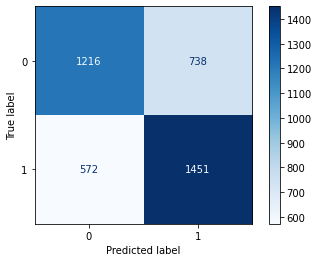

In [19]:
#numero feature < del numero di sample, quindi usare dual = False
svc = LinearSVC(dual=False)
svc.fit(training_set, tr_labels) 
predictions = svc.predict(training_set)
ConfusionMatrixDisplay.from_predictions(tr_labels, predictions, cmap='Blues')

In [20]:
print(classification_report(tr_labels, predictions)) # output_dict=True

              precision    recall  f1-score   support

           0       0.68      0.62      0.65      1954
           1       0.66      0.72      0.69      2023

    accuracy                           0.67      3977
   macro avg       0.67      0.67      0.67      3977
weighted avg       0.67      0.67      0.67      3977



### Validation

In [22]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.dummy import DummyClassifier
import numpy as np

In [23]:
splitter = KFold(n_splits=5, random_state=42, shuffle=True)
folds = list(splitter.split(training_set))


tr_labels=np.asarray(tr_labels)
i=1
real_lbls = []
predicted_lbls = []

for fold in folds:
    print(f'-------------------------Fold n.{i} just started!-------------------------')
    #si creano i set per ogni fold, training e test
    train_index = fold[0]
    test_index = fold[1]
    #train set
    x_train = training_set[train_index]
    y_train= tr_labels[train_index]
    #test set
    x_test = training_set[test_index]
    y_test = tr_labels[test_index]
    #inizio del training
    ksvc = LinearSVC(dual=False)
    ksvc.fit(x_train, y_train)
    #predictions
    pred = ksvc.predict(x_test)
    acc = accuracy_score(y_test, pred)
    #usiamo un Dummy Classifier come Baseline
    dummy = DummyClassifier(strategy="most_frequent")
    dummy.fit(x_train, y_train)
    dummy_acc = dummy.score(x_test, y_test)
    real_lbls+=y_test.tolist()
    predicted_lbls+=pred.tolist()
    print("---> Prediction: ")
    print(f"Accuracy del modello: {acc}\nAccuracy della baseline: {dummy_acc}")
    i+=1
        

-------------------------Fold n.1 just started!-------------------------
---> Prediction: 
Accuracy del modello: 0.6494974874371859
Accuracy della baseline: 0.5213567839195979
-------------------------Fold n.2 just started!-------------------------
---> Prediction: 
Accuracy del modello: 0.5979899497487438
Accuracy della baseline: 0.507537688442211
-------------------------Fold n.3 just started!-------------------------
---> Prediction: 
Accuracy del modello: 0.6339622641509434
Accuracy della baseline: 0.4716981132075472
-------------------------Fold n.4 just started!-------------------------
---> Prediction: 
Accuracy del modello: 0.610062893081761
Accuracy della baseline: 0.539622641509434
-------------------------Fold n.5 just started!-------------------------
---> Prediction: 
Accuracy del modello: 0.640251572327044
Accuracy della baseline: 0.5031446540880503


In [24]:
real_lbls=list(real_lbls)
predicted_lbls=list(predicted_lbls)

In [25]:
print(classification_report(real_lbls, predicted_lbls, zero_division=0))

              precision    recall  f1-score   support

           0       0.63      0.58      0.60      1954
           1       0.62      0.67      0.65      2023

    accuracy                           0.63      3977
   macro avg       0.63      0.63      0.63      3977
weighted avg       0.63      0.63      0.63      3977



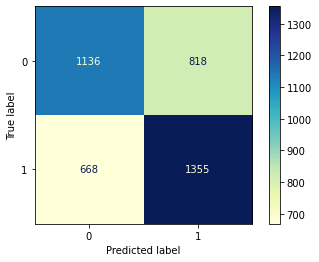

In [26]:
ConfusionMatrixDisplay.from_predictions(real_lbls, predicted_lbls, cmap='YlGnBu')

### Test

Testing sul vero test set fornito da EvalITA

In [27]:
test_predictions = ksvc.predict(test_set)
print(classification_report(ts_labels, test_predictions, zero_division=0))

              precision    recall  f1-score   support

           0       0.63      0.68      0.65       437
           1       0.65      0.59      0.62       435

    accuracy                           0.64       872
   macro avg       0.64      0.64      0.63       872
weighted avg       0.64      0.64      0.63       872



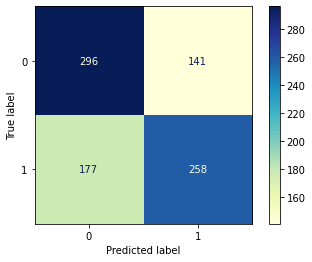

In [28]:
ConfusionMatrixDisplay.from_predictions(ts_labels, test_predictions, cmap='YlGnBu')

In [29]:
#si confrontano gli score con quelli di una baseline
baseline = DummyClassifier(strategy="most_frequent")
baseline.fit(training_set, tr_labels)
dummy_preds = baseline.predict(test_set)
print("------------------------------BASELINE-----------------------------\n")
print(classification_report(ts_labels, dummy_preds, zero_division=0))

------------------------------BASELINE-----------------------------

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       437
           1       0.50      1.00      0.67       435

    accuracy                           0.50       872
   macro avg       0.25      0.50      0.33       872
weighted avg       0.25      0.50      0.33       872



### Feature importance

In [30]:
import matplotlib.pyplot as plt

Feature importance


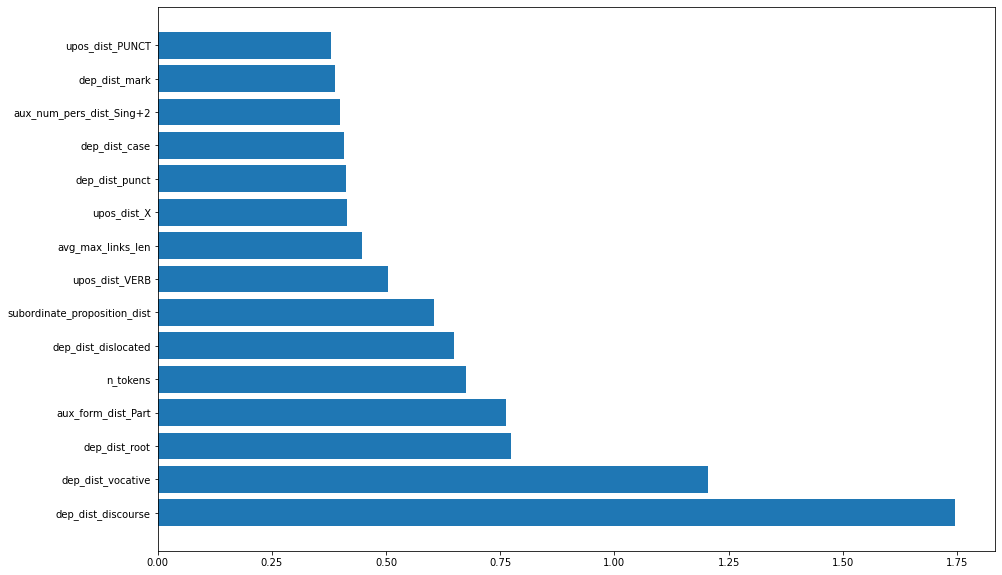

In [35]:
coefs = ksvc.coef_[0]
feature_imp = {feature_name: coef for feature_name, coef in zip(feature_names, coefs)}
feature_imp = dict(sorted(feature_imp.items(), key=lambda item: item[1], reverse=True))

print(f'Feature importance')
plt.figure(figsize=[15,10])
plt.barh(range(15), list(feature_imp.values())[:15], align='center')
plt.yticks(range(15), list(feature_imp.keys())[:15])
plt.show()